In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 하루

In [2]:
df = pd.read_csv(
    "../input/10min/ontune2016.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52008, 2)


,date,value
0,2020-03-28 09:00:00,16
1,2020-03-28 09:10:00,9
2,2020-03-28 09:20:00,9
3,2020-03-28 09:30:00,9
4,2020-03-28 09:40:00,9


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df.tail()

,ds,y
52003,2021-03-26 08:10:00,12
52004,2021-03-26 08:20:00,12
52005,2021-03-26 08:30:00,12
52006,2021-03-26 08:40:00,13
52007,2021-03-26 08:50:00,12


In [4]:
train = df.iloc[:int(df.shape[0] * 0.8)]
valid = df.iloc[int(df.shape[0] * 0.2):]
valid["days"] = valid["ds"].dt.date
valid = valid.groupby("days")["y"].agg("mean")

In [5]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [50, 100, 200, 300, 400, 500]),
        "batch_size": 64,
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 0, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)

    return val_rmse

In [6]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

[I 2021-05-15 17:55:43,511] A new study created in memory with name: no-name-8bda5cc9-f234-4d9d-b5c9-e521bb6fb511
Epoch[100/100]: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s, MSELoss=0.0793, MAE=3.12, RegLoss=0]
[I 2021-05-15 17:57:12,274] Trial 0 finished with value: 41.058655694420416 and parameters: {'epochs': 100, 'num_hidden_layers': 0, 'learning_rate': 0.08675143843171859, 'changepoints_range': 0.89, 'n_changepoints': 31}. Best is trial 0 with value: 41.058655694420416.
Epoch[100/100]: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s, MSELoss=0.0788, MAE=3.12, RegLoss=0]
[I 2021-05-15 17:58:43,724] Trial 1 finished with value: 36.34478301401968 and parameters: {'epochs': 100, 'num_hidden_layers': 1, 'learning_rate': 0.05295088673159155, 'changepoints_range': 0.865, 'n_changepoints': 24}. Best is trial 1 with value: 36.34478301401968.
Epoch[500/500]: 100%|██████████| 500/500 [07:28<00:00,  1.11it/s, MSELoss=0.0782, MAE=3.1, RegLoss=0] 
[I 2021-05-15 18:06:12,706] Trial 2 fini

Epoch[200/200]: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s, MSELoss=0.0784, MAE=3.16, RegLoss=0]
[I 2021-05-15 19:09:49,531] Trial 17 finished with value: 25.748310071587827 and parameters: {'epochs': 200, 'num_hidden_layers': 4, 'learning_rate': 0.01734481699393068, 'changepoints_range': 0.8200000000000001, 'n_changepoints': 26}. Best is trial 9 with value: 20.68509903152376.
Epoch[400/400]: 100%|██████████| 400/400 [05:59<00:00,  1.11it/s, MSELoss=0.0768, MAE=3.07, RegLoss=0]
[I 2021-05-15 19:15:49,986] Trial 18 finished with value: 33.557753690922716 and parameters: {'epochs': 400, 'num_hidden_layers': 2, 'learning_rate': 0.004841884784959123, 'changepoints_range': 0.8460000000000001, 'n_changepoints': 29}. Best is trial 9 with value: 20.68509903152376.
Epoch[200/200]: 100%|██████████| 200/200 [02:56<00:00,  1.13it/s, MSELoss=0.0806, MAE=3.25, RegLoss=0]
[I 2021-05-15 19:18:47,452] Trial 19 finished with value: 22.823049218343982 and parameters: {'epochs': 200, 'num_hidden_lay

In [7]:
prophet_params = study.best_params
prophet_params["batch_size"] = 64
prophet_params["seasonality_mode"] = "additive"
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [8]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(train, freq="1D")
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[400/400]: 100%|██████████| 400/400 [05:55<00:00,  1.13it/s, MSELoss=0.08, MAE=3.25, RegLoss=0]  


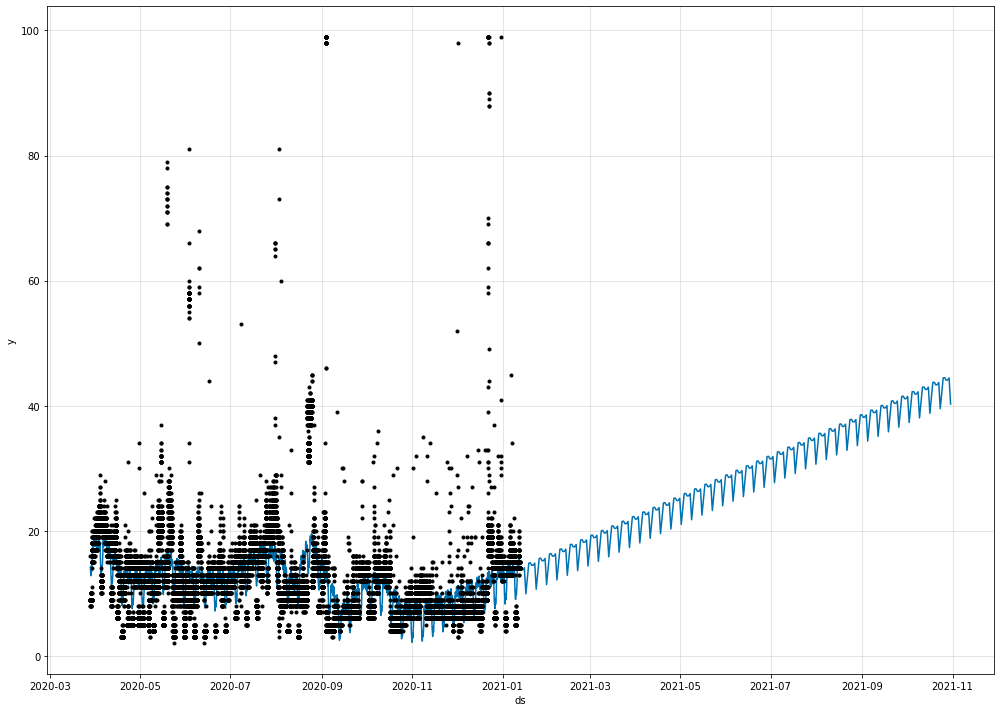

In [9]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

In [10]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1D")
future = model.make_future_dataframe(df, periods=144, n_historic_predictions=True)
forecast = model.predict(future)

Epoch[400/400]: 100%|██████████| 400/400 [07:29<00:00,  1.12s/it, MSELoss=0.199, MAE=5.05, RegLoss=0]


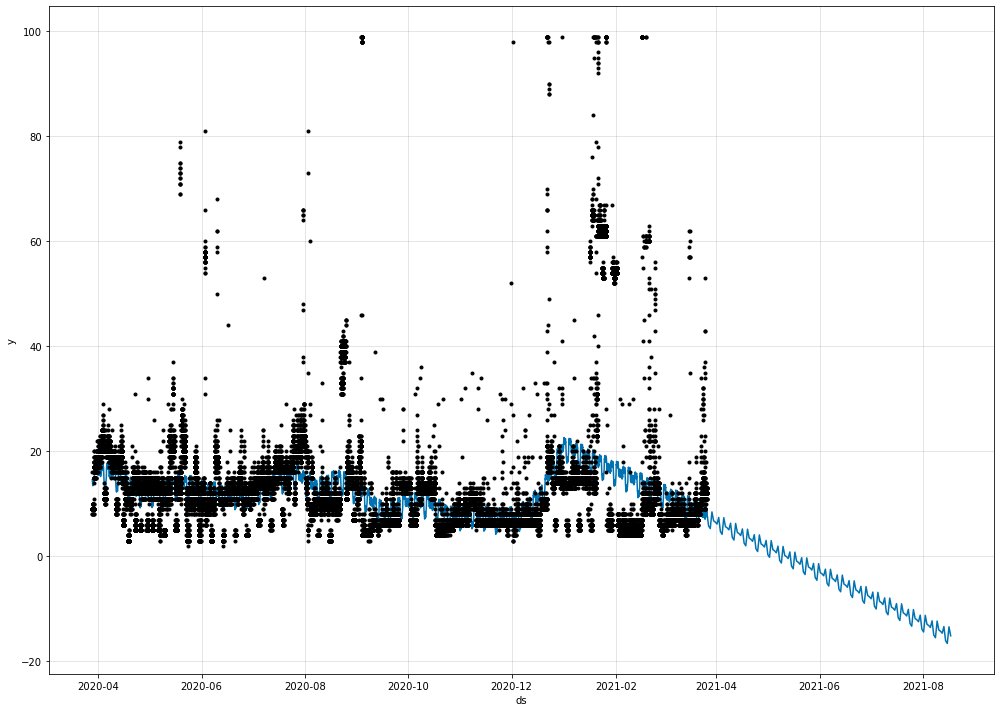

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()